In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import classifiers
from datetime import datetime, timezone
import plotly.graph_objects as go
import itertools
from autocorrect import Speller
import re, string, timeit
import plotly.express as px
from wordcloud import WordCloud
import scipy
import pyreadstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daisy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
sightings = pd.read_pickle('sightings_cleaned_UTC.pkl')
#sightings.head(8)

Preliminary WordCLouds to visualize word frequencies in the Detailed summaries and the shape column.

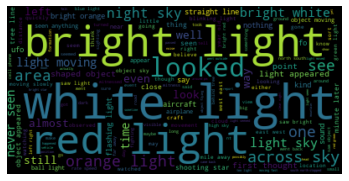

In [3]:
text = " ".join(t for t in sightings.Detail_Summary_nltk.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

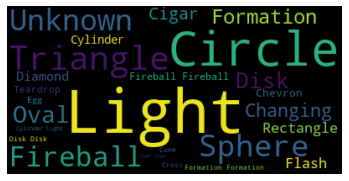

In [4]:
text = " ".join(t for t in sightings.Shape.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [5]:
# creating the Bag of words Model
BagOfWords = []
for s in sightings['Detail_Summary_nltk']:
    s = re.sub(r' . ', " ", s)
    s = re.sub(r'[\(\)\[\]\^\$\+\*\.\?\/!@#%&{}\'\",;:]', "", s)
    words = nltk.word_tokenize(s)
    BagOfWords.append(words)

In [6]:
BagOfWords_series = pd.Series(BagOfWords) 

In [7]:
BagOfWords_list = ''.join(BagOfWords_series.str.join(',').tolist()).split(',')

In [8]:
ngram_counts = Counter(ngrams(BagOfWords_list, 3))
ngram_counts.most_common(10)

[(('bright', 'white', 'light'), 2450),
 (('never', 'seen', 'anything'), 2253),
 (('seen', 'anything', 'like'), 1772),
 (('high', 'rate', 'speed'), 1322),
 (('bright', 'orange', 'light'), 989),
 (('moving', 'across', 'sky'), 972),
 (('saw', 'bright', 'light'), 718),
 (('light', 'looked', 'like'), 708),
 (('looked', 'like', 'star'), 691),
 (('get', 'better', 'look'), 667)]

In [9]:
sid_obj = SentimentIntensityAnalyzer()
def sentiment_Vader(summary)-> float:
    """ 
    This function converts un-cleaned text, i.e.,text containing punctuation
    and capitalization along with stopwords, into a sentiment value.If value is >= 0.5, 
    then positive, if <=-0.5, then negative, else neutral. 
    
    Args-
        summary(str): un-cleaned text summary
    Return-
        sentiment value(float)
    """
    return sid_obj.polarity_scores(summary)['compound']

In [10]:
sia = SentimentIntensityAnalyzer()
def sentiment_nltk(summary) -> float:
    """ 
    This function converts cleaned text, i.e.,text containing punctuation
    and capitalization along with stopwords, into a sentiment value. Compound 
    has a range of -1 (negative) to +1 (positive), if 0 then neutral.
    
    Args-
        summary(str): un-cleaned text summary
    Return-
        sentiment value(float)
    """
    return sia.polarity_scores(summary)["compound"]

In [11]:
def sentiment_TextBlob(summary):
    """ 
    This function converts cleaned text, i.e.,text containing punctuation
    and capitalization along with stopwords, into a sentiment value. Compound 
    has a range of -1 (negative) to +1 (positive), if 0 then neutral.
    
    Args-
        summary(str): un-cleaned text summary
    Return-
        sentiment value(float)
    """
    return TextBlob(summary).sentiment[0]

In [12]:
def objectivity(summary) -> float:
    """ 
    This function converts cleaned text, i.e.,text containing punctuation
    and capitalization along with stopwords, into a sentiment value. Compound 
    has a range of -1 (negative) to +1 (positive), if 0 then neutral.
    
    Args-
        summary(str): un-cleaned text summary
    Return-
        sentiment value(float): within the range [0.0, 1.0] 
        where 0.0 is a very objective sentence and 1.0 is very subjective
    """
    return TextBlob(summary).sentiment[1]
   

In [13]:
sightings['sentiment_Vader'] = sightings['Detail_Summary'].apply(sentiment_Vader)
sightings['sentiment_nltk'] = sightings['Detail_Summary_nltk'].apply(sentiment_nltk)
sightings['sentiment_TextBlob'] = sightings['Detail_Summary_nltk'].apply(sentiment_TextBlob)
sightings['objectivity_TextBlob'] = sightings['Detail_Summary_nltk'].apply(objectivity)

In [14]:
#save file
fileName = 'sightings_add_features.pkl'
sightings.to_pickle(fileName, protocol = 4)

In [15]:
state_abr = {"Hawaii":"HI", "Alaska":"AK", "Washington":"WA", "Oregon":"OR", "California":"CA",
                        "Arizona":"AZ", "Utah":"UT", "Idaho":"ID", "Montana":"MT", "Wyoming":"WY", "Colorado":"CO",
                        "New Mexico":"NM", "Texas":"TX", "Oklahoma":"OK", "Kansas":"KS", "Nebraska":"NE", 
                        "South Dakota":"SD", "North Dakota":"ND", "Minnesota":"MN", "Iowa":"IA", "Missouri":"MO",
                        "Arkansas":"AR", "Louisiana":"LA", "Wisconsin":"WI", "Illinois":"IL", "Mississippi":"MS",
                        "Alabama":"AL", "Georgia":"GA", "Florida":"FL", "Tennessee":"TN", "Kentucky":"KY", "Indiana":"IN",
                        "Michigan":"MI", "South Carolina":"SC", "North Carolina":"NC", "Virginia":"VA",
                        "West Virginia":"WV", "Ohio":"OH", "Pennsylvania":"PA", "Maryland":"MD", "Delaware":"DE",
                        "New Jersey":"NJ", "New York":"NY", "Connecticut":"CT", "Rhode Island":"RI", 
                        "Massachusetts":"MA", "Vermont":"VT", "New Hampshire":"NH", "Maine":"ME",
                        "District of Columbia":"DC", "Nevada":"NV", "Puerto Rico":"PR"}

In [16]:
byStateSentObj = sightings[['State', 'sentiment_Vader', 'sentiment_nltk',
       'sentiment_TextBlob', 'objectivity_TextBlob']].copy().replace(['', 'ON', 'BC'], None)
byStateSentObj.rename(columns = {'State':'state'}, inplace = True)
byStateSentObj['state'] = byStateSentObj['state'].apply(lambda x: list(state_abr.keys())[list(state_abr.values()).index(x)])
byStateSentObj = byStateSentObj.groupby('state').agg({'sentiment_Vader': ['mean','median'], 'sentiment_nltk': ['mean','median'], 'sentiment_TextBlob': ['mean','median'],'objectivity_TextBlob':['mean', 'median']}).reset_index()
byStateSentObj.head()

state sentiment_Vader         sentiment_nltk           \
                         mean  median           mean   median   
0     Alabama        0.254666  0.3400       0.398392  0.56470   
1      Alaska        0.244099  0.3612       0.400941  0.46030   
2     Arizona        0.263664  0.3612       0.394860  0.50000   
3    Arkansas        0.247887  0.3071       0.398796  0.51855   
4  California        0.312512  0.4404       0.451876  0.61240   

  sentiment_TextBlob           objectivity_TextBlob            
                mean    median                 mean    median  
0           0.130834  0.125000             0.423527  0.421429  
1           0.141282  0.133333             0.441974  0.443635  
2           0.137682  0.134167             0.432791  0.435821  
3           0.147803  0.142532             0.435235  0.429107  
4           0.134621  0.133209             0.434680  0.437110

In [17]:
#save file
fileName = 'sightingsCapstone.pkl'
sightings.to_pickle(fileName)

<AxesSubplot:>

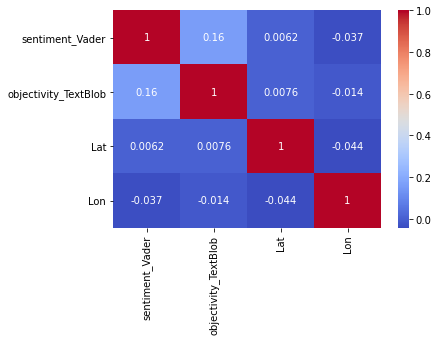

In [18]:
#load fresh file to work with
sightings_sentiment = pd.read_pickle(fileName)

sns.heatmap(sightings_sentiment[['sentiment_Vader', 'objectivity_TextBlob', 'Lat', 'Lon']].corr(), annot = True, fmt='.2g',cmap= 'coolwarm') 

Count trends by Year, Day, and Hour

In [19]:
#visualize data

ufo_df = sightings_sentiment[['sentiment_Vader', 'objectivity_TextBlob', 'Lat', 'Lon', 'Time_UTC', 'City', 'State', 'Country', 'Shape']].copy()
ufo_df = ufo_df[ufo_df['Country'] == 'United States']
ufo_df.dropna(how='any', inplace=True)

# Set x axis, group y axis
ufo_df['year'] = ufo_df['Time_UTC'].dt.year
ufo_df['day'] = ufo_df['Time_UTC'].dt.dayofyear
ufo_df['hour'] = ufo_df['Time_UTC'].dt.hour


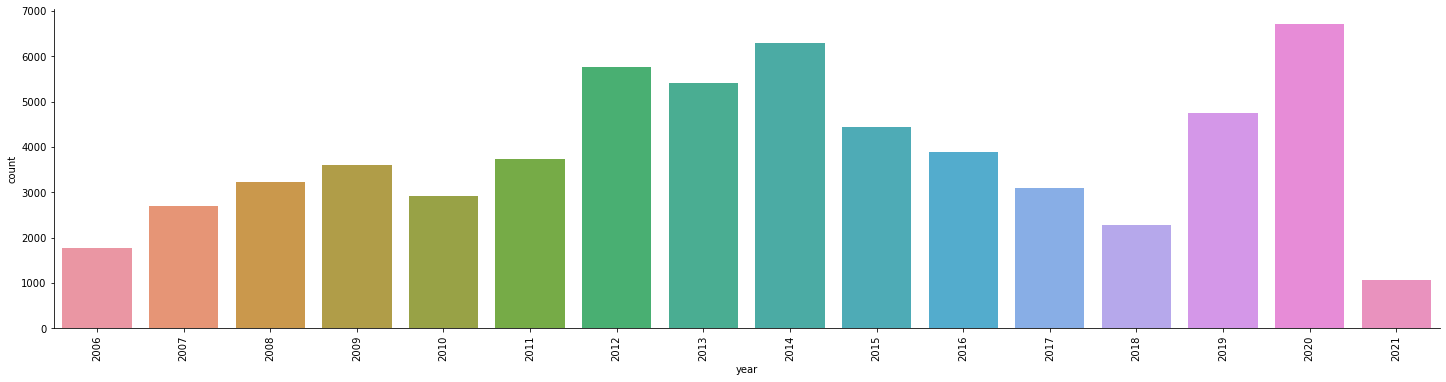

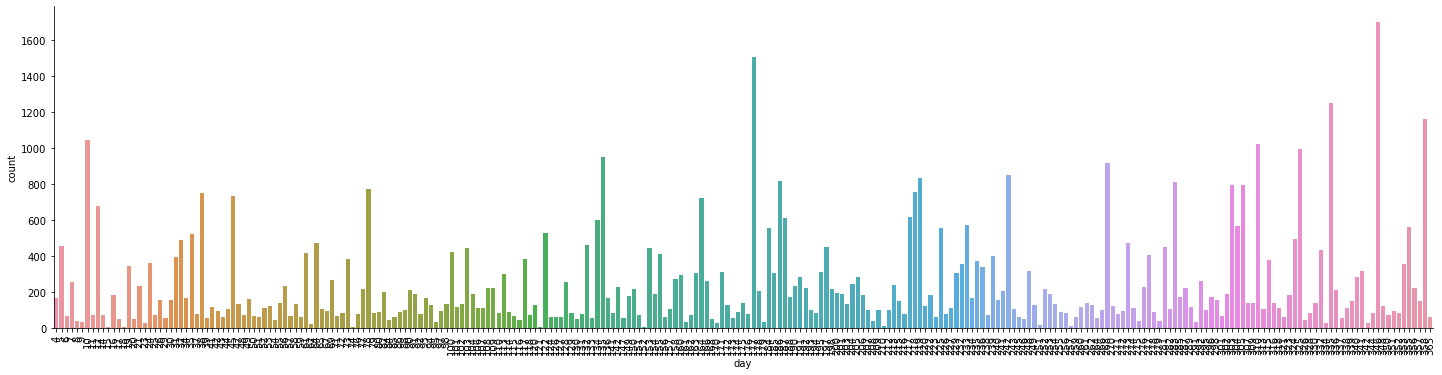

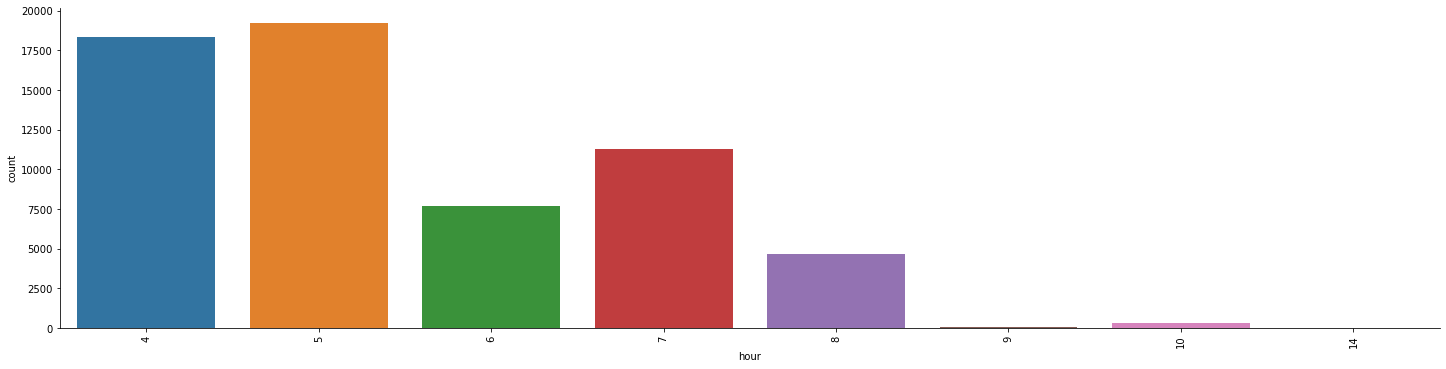

In [20]:
features = ['year', 'day', 'hour']

for i in range(3):
    sns.catplot(x=features[i], kind = 'count', data = ufo_df,height=5, aspect=4).set_xticklabels(rotation=90)


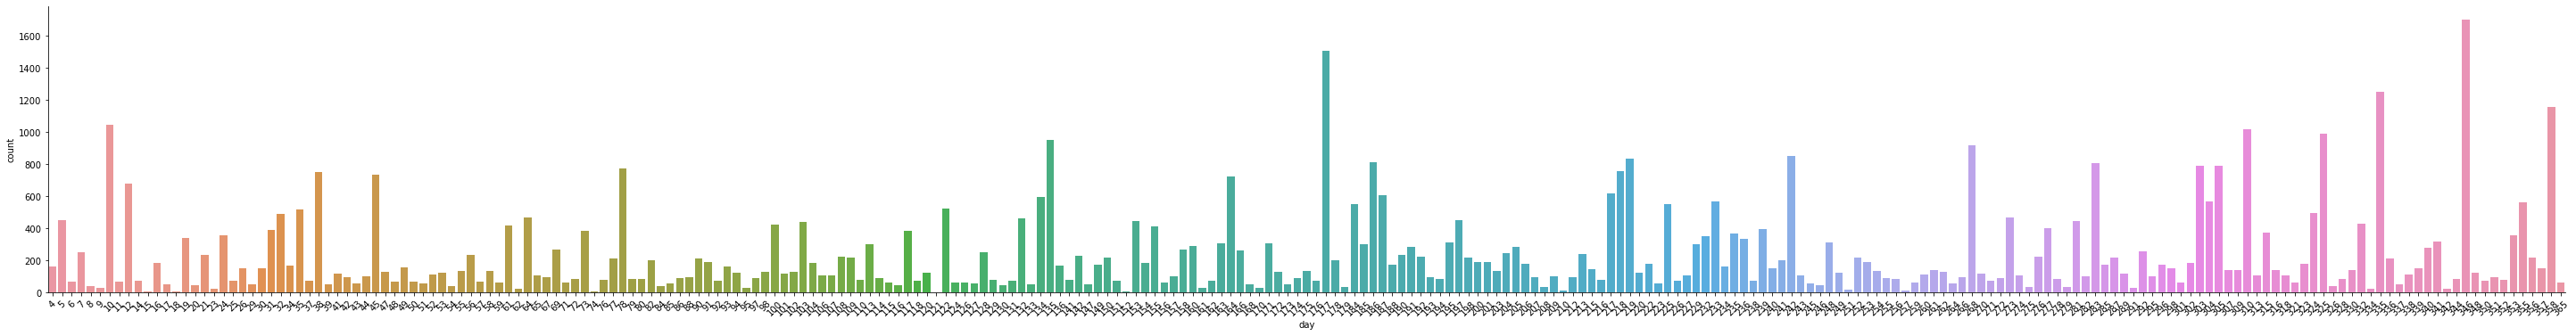

In [21]:
g = sns.catplot(x="day", kind = 'count', data = ufo_df, height=5, aspect=8)
g.set_xticklabels(rotation=45)

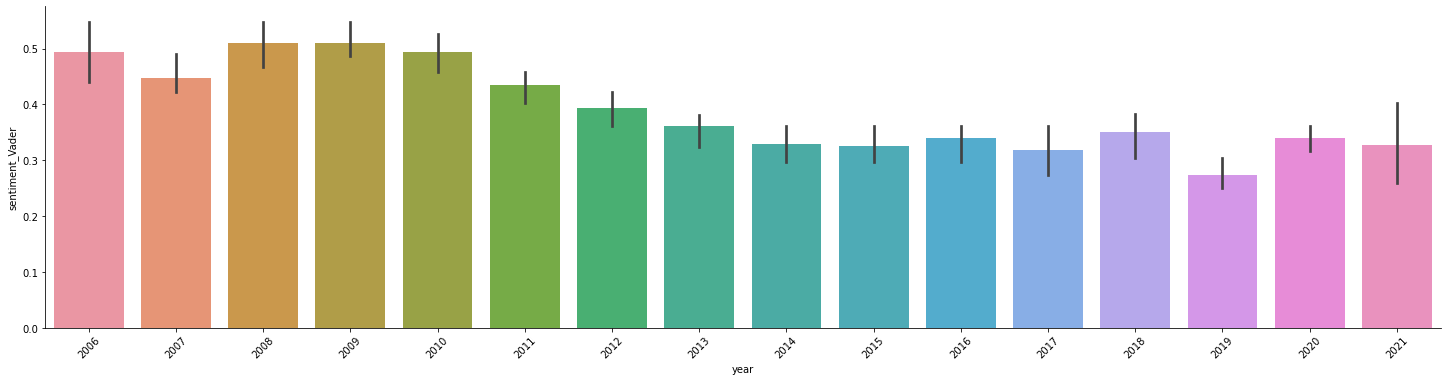

In [22]:
g = sns.catplot(x="year", y="sentiment_Vader", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

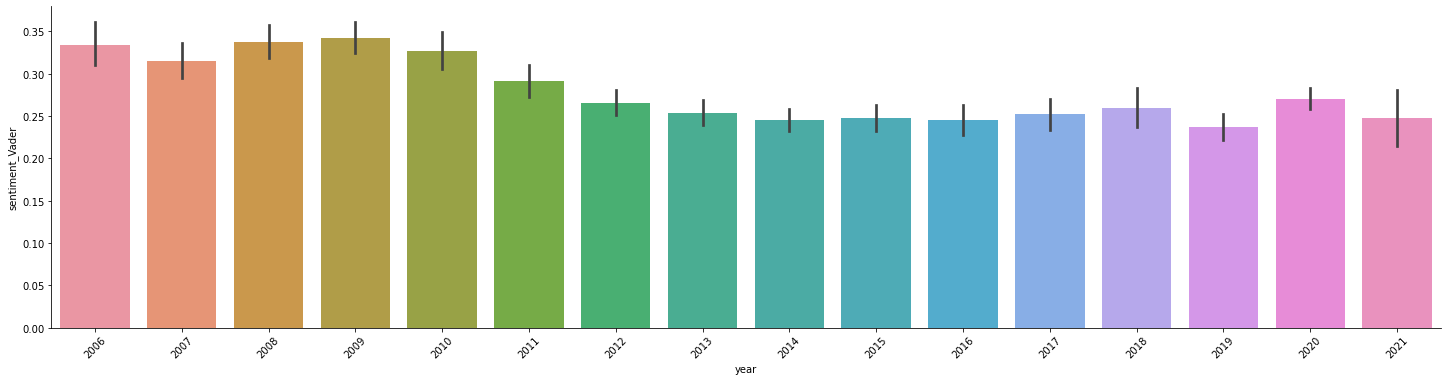

In [23]:
g = sns.catplot(x="year", y="sentiment_Vader", estimator= np.mean ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

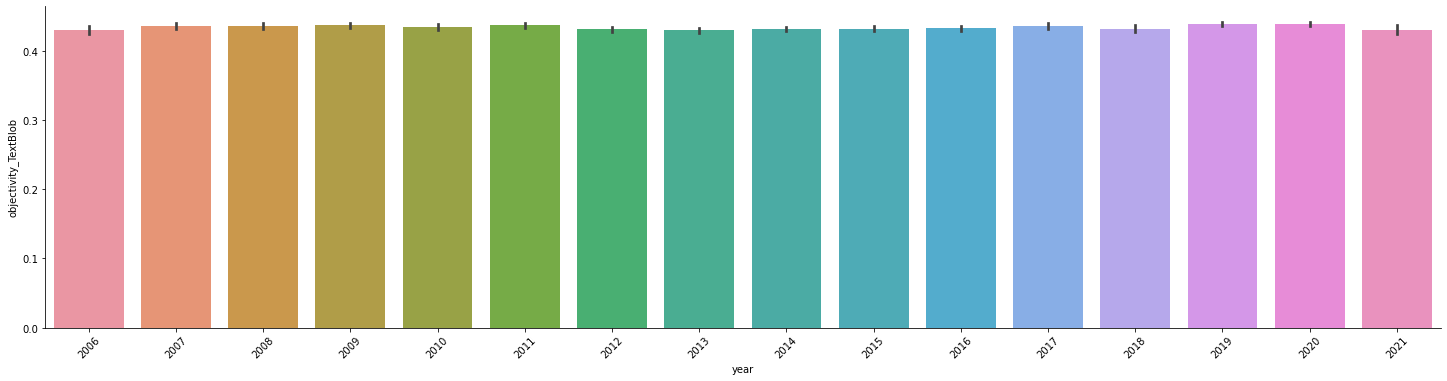

In [24]:
g = sns.catplot(x="year", y="objectivity_TextBlob", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

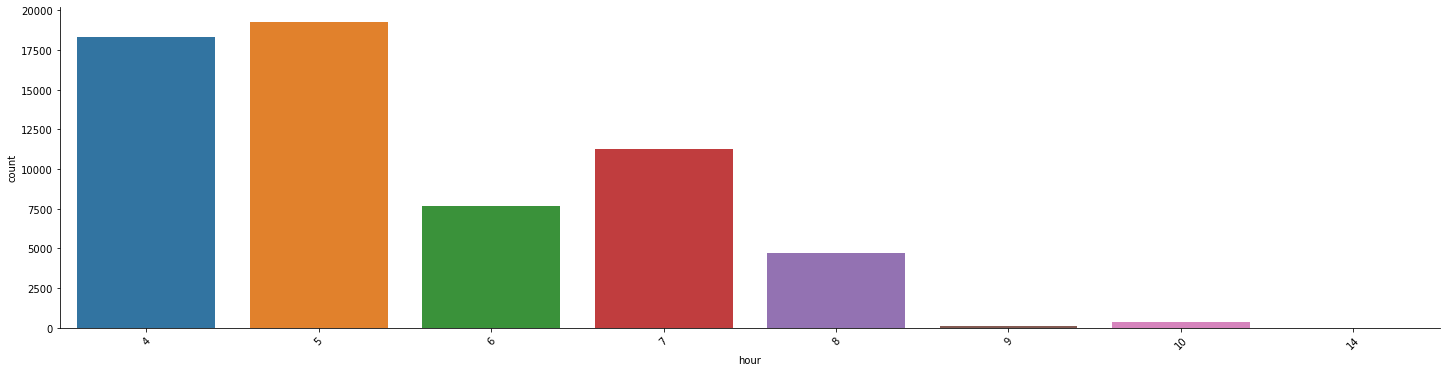

In [25]:
g = sns.catplot(x="hour", kind = 'count', data = ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

Map Visulaizations by State: Grouping by State to visualize the sentiment and objectivity weighted by state population.

In [26]:
states_sentiment = ufo_df.groupby(['State'])['sentiment_Vader'].max().reset_index()
#states_sentiment

In [27]:
states_objectivity = ufo_df.groupby(['State'])['objectivity_TextBlob'].median().reset_index()

In [28]:
states_count = ufo_df.groupby(['State']).size().reset_index()
states_count.rename(columns = {0:'Count'}, inplace = True)


In [29]:
sightingsDict = {states_count.iloc[i][0]:states_count.iloc[i][1] for i in range(len(states_count.State))}
sightingsDict["PR"] = None

objectDict = {states_objectivity.iloc[i][0]:states_objectivity.iloc[i][1] for i in range(len(states_objectivity.State))}
objectDict["PR"] = None

sentimentDict = {states_sentiment.iloc[i][0]:states_sentiment.iloc[i][1] for i in range(len(states_sentiment.State))}
sentimentDict["PR"] = None

In [30]:
state_abr = {"Hawaii":"HI", "Alaska":"AK", "Washington":"WA", "Oregon":"OR", "California":"CA",
                        "Arizona":"AZ", "Utah":"UT", "Idaho":"ID", "Montana":"MT", "Wyoming":"WY", "Colorado":"CO",
                        "New Mexico":"NM", "Texas":"TX", "Oklahoma":"OK", "Kansas":"KS", "Nebraska":"NE", 
                        "South Dakota":"SD", "North Dakota":"ND", "Minnesota":"MN", "Iowa":"IA", "Missouri":"MO",
                        "Arkansas":"AR", "Louisiana":"LA", "Wisconsin":"WI", "Illinois":"IL", "Mississippi":"MS",
                        "Alabama":"AL", "Georgia":"GA", "Florida":"FL", "Tennessee":"TN", "Kentucky":"KY", "Indiana":"IN",
                        "Michigan":"MI", "South Carolina":"SC", "North Carolina":"NC", "Virginia":"VA",
                        "West Virginia":"WV", "Ohio":"OH", "Pennsylvania":"PA", "Maryland":"MD", "Delaware":"DE",
                        "New Jersey":"NJ", "New York":"NY", "Connecticut":"CT", "Rhode Island":"RI", 
                        "Massachusetts":"MA", "Vermont":"VT", "New Hampshire":"NH", "Maine":"ME",
                        "District of Columbia":"DC", "Nevada":"NV", "Puerto Rico":"PR"}

In [31]:
state_pop = pd.read_csv('StatesPop.csv')
state_pop.State.replace(state_abr, inplace=True)

# The proportion of each state's population to the nation's population: the sum of the Proportions is 1
state_pop["Proportion"] = state_pop.Pop/state_pop.Pop.sum()

# The ratio of the number of sightings to the each state's population. Note that Puerto Rico (PR) is NaN.
state_pop["Sightings"] = pd.Series([sightingsDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Sightings_per_capita"] = state_pop.Sightings/state_pop.Pop

# sentiment weighted by proportion of state population to national population
state_pop["Sentiment"] = pd.Series([sentimentDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Weighted_sentiment"] = state_pop.Sentiment*state_pop.Proportion

# objectivity weighted by proportion of state population to national population
state_pop["Objectivity"] = pd.Series([objectDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Weighted_objectivity"] = state_pop.Objectivity*state_pop.Proportion

state_pop.head(5)

rank State       Pop  Growth   Pop2018   Pop2010  growthSince2010  Percent  \
0     1    CA  39613493  0.0038  39461588  37319502           0.0615   0.1184   
1     2    TX  29730311  0.0385  28628666  25241971           0.1778   0.0889   
2     3    FL  21944577  0.0330  21244317  18845537           0.1644   0.0656   
3     4    NY  19299981 -0.0118  19530351  19399878          -0.0051   0.0577   
4     5    PA  12804123  0.0003  12800922  12711160           0.0073   0.0383   

    density  Proportion  Sightings  Sightings_per_capita  Sentiment  \
0  254.2929    0.118413     7168.0              0.000181     0.9997   
1  113.8081    0.088870     2702.0              0.000091     0.9989   
2  409.2229    0.065597     4162.0              0.000190     0.9999   
3  409.5400    0.057691     2619.0              0.000136     0.9989   
4  286.1704    0.038274     2491.0              0.000195     0.9983   

   Weighted_sentiment  Objectivity  Weighted_objectivity  
0            0.118377     0.437075              0.051755  
1            0.088772     0.432131              0.038403  
2            0.065590     0.430303              0.028226  
3            0.057628     0.433178              0.024991  
4            0.038209     0.429167              0.016426

In [32]:
fig = px.choropleth(state_pop,
                    locations='State',
                    color='Weighted_sentiment',
                    color_continuous_scale='spectral_r',
                    hover_name='Weighted_sentiment',
                    locationmode='USA-states',
                    labels={'Weighted_sentiment':'Sentiment/Population'},
                    scope='usa')
fig.show()

Religious Landscape Surveys from 2007 and 2014

In [33]:
religion_2007 = 'Religious Landscape Survey Data - Continental US.sav'
religion2007df, metadata = pyreadstat.read_sav(religion_2007, apply_value_formats=True)

In [34]:
religion_2014 = 'Dataset - Pew Research Center 2014 Religious Landscape Study National Telephone Survey - Version 1.1 - December 1 2016.sav'
religion2014df, metadata = pyreadstat.read_sav(religion_2014, apply_value_formats=True)

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
religion_encoded = le.fit_transform(religion2007df['q16'])
religion_encoded

array([44, 44, 44, ..., 47, 47, 39])

In [36]:
relByState = religion2007df.groupby("state")['q16'].apply(lambda x: x.tolist()).reset_index()

#for i in range(len(relByState)):
#    fig = px.histogram(relByState, x=relByState['q16'][i], title=relByState['state'][i])
#    fig.show()

religion2007df_reduced = religion2007df[['state', 'q16', 'party']].copy().apply(lambda x: x.str.strip())


def relCode(x):
    if x == 'Nothing in particular' or x == 'Atheist (do not believe in God)' \
    or x== 'Agnostic (not sure if there is a God)' or x=='Nihilist (VOL)':
        return 0
    elif x == 'Protestant':
        return 1
    elif x == 'Mormon (Church of Jesus Christ of Latter-day Saints/LDS)':
        return 2
    elif x == 'Roman Catholic':
        return 3
    elif x == 'Jewish (Judaism)':
        return 4
    else:
        return 5

    
def partyCode(x):
    if x == 'Republican':
        return 1
    elif x == 'Democrat':
        return 2
    elif x == 'Independent':
        return 3
    else:
        return 0

religion2007df_reduced['relCode2007'] = religion2007df_reduced['q16'].apply(relCode)
religion2007df_reduced['partyCode2007'] = religion2007df_reduced['party'].apply(partyCode)

relByStateRed2007 = religion2007df_reduced.groupby("state")['relCode2007'].apply(lambda x: x.tolist()).reset_index()
partyByStateRed2007 = religion2007df_reduced.groupby("state")['partyCode2007'].apply(lambda x: x.tolist()).reset_index()

#for i in range(len(relByStateRed)):
#    fig = px.histogram(relByStateRed, x=relByStateRed['relCode'][i], title=relByStateRed['state'][i])
#    fig.show()

relByStateRed2007['relFreq2007'] = relByStateRed2007['relCode2007'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
partyByStateRed2007['partyFreq2007'] = partyByStateRed2007['partyCode2007'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
split_reldf = pd.DataFrame(relByStateRed2007['relFreq2007'].tolist(), columns=['rel0_2007', 'rel1_2007', 'rel2_2007', 'rel3_2007', 'rel4_2007', 'rel5_2007'])
split_partydf = pd.DataFrame(partyByStateRed2007['partyFreq2007'].tolist(), columns=['par0_2007', 'par1_2007', 'par2_2007', 'par3_2007'])

byState = relByStateRed2007[['state']].join(split_reldf).join(split_partydf)
byState.head()

state  rel0_2007  rel1_2007  rel2_2007  rel3_2007  rel4_2007  \
0     Alabama   0.071953   0.826725   0.004405   0.066079   0.001468   
1     Arizona   0.200692   0.394464   0.041522   0.249135   0.015571   
2    Arkansas   0.092593   0.804233   0.005291   0.047619   0.050265   
3  California   0.198657   0.019026   0.026021   0.340795   0.267208   
4    Colorado   0.227119   0.427119   0.022034   0.189831   0.022034   

   rel5_2007  par0_2007  par1_2007  par2_2007  par3_2007  
0   0.029369   0.120411   0.330396   0.317181   0.232012  
1   0.098616   0.114187   0.302768   0.254325   0.328720  
2        NaN   0.108466   0.227513   0.380952   0.283069  
3   0.148293   0.114717   0.340515   0.239508   0.305260  
4   0.111864   0.064407   0.269492   0.262712   0.403390

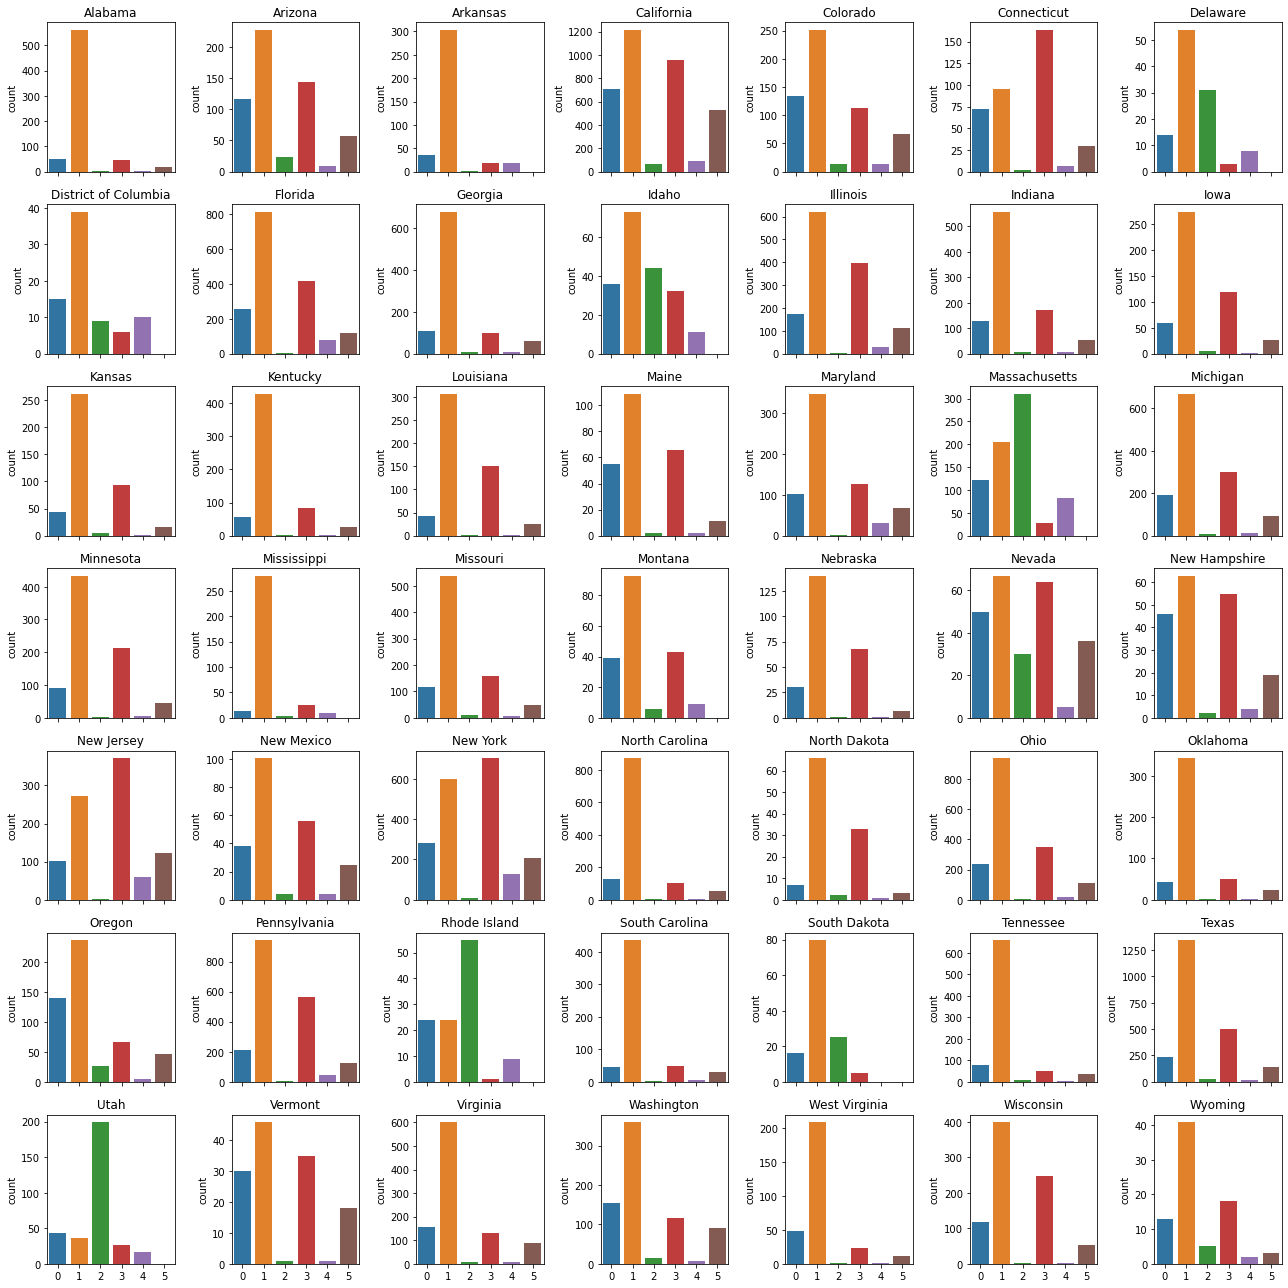

In [37]:
fig,axes = plt.subplots(7,7,figsize=(18,18), sharex=True)
axes = axes.ravel() # flatten
for i in range(len(relByStateRed2007)):
    sns.countplot(ax= axes[i], x=relByStateRed2007['relCode2007'][i], data=relByStateRed2007).set(title =relByStateRed2007['state'][i]);
    
plt.tight_layout()
plt.show()

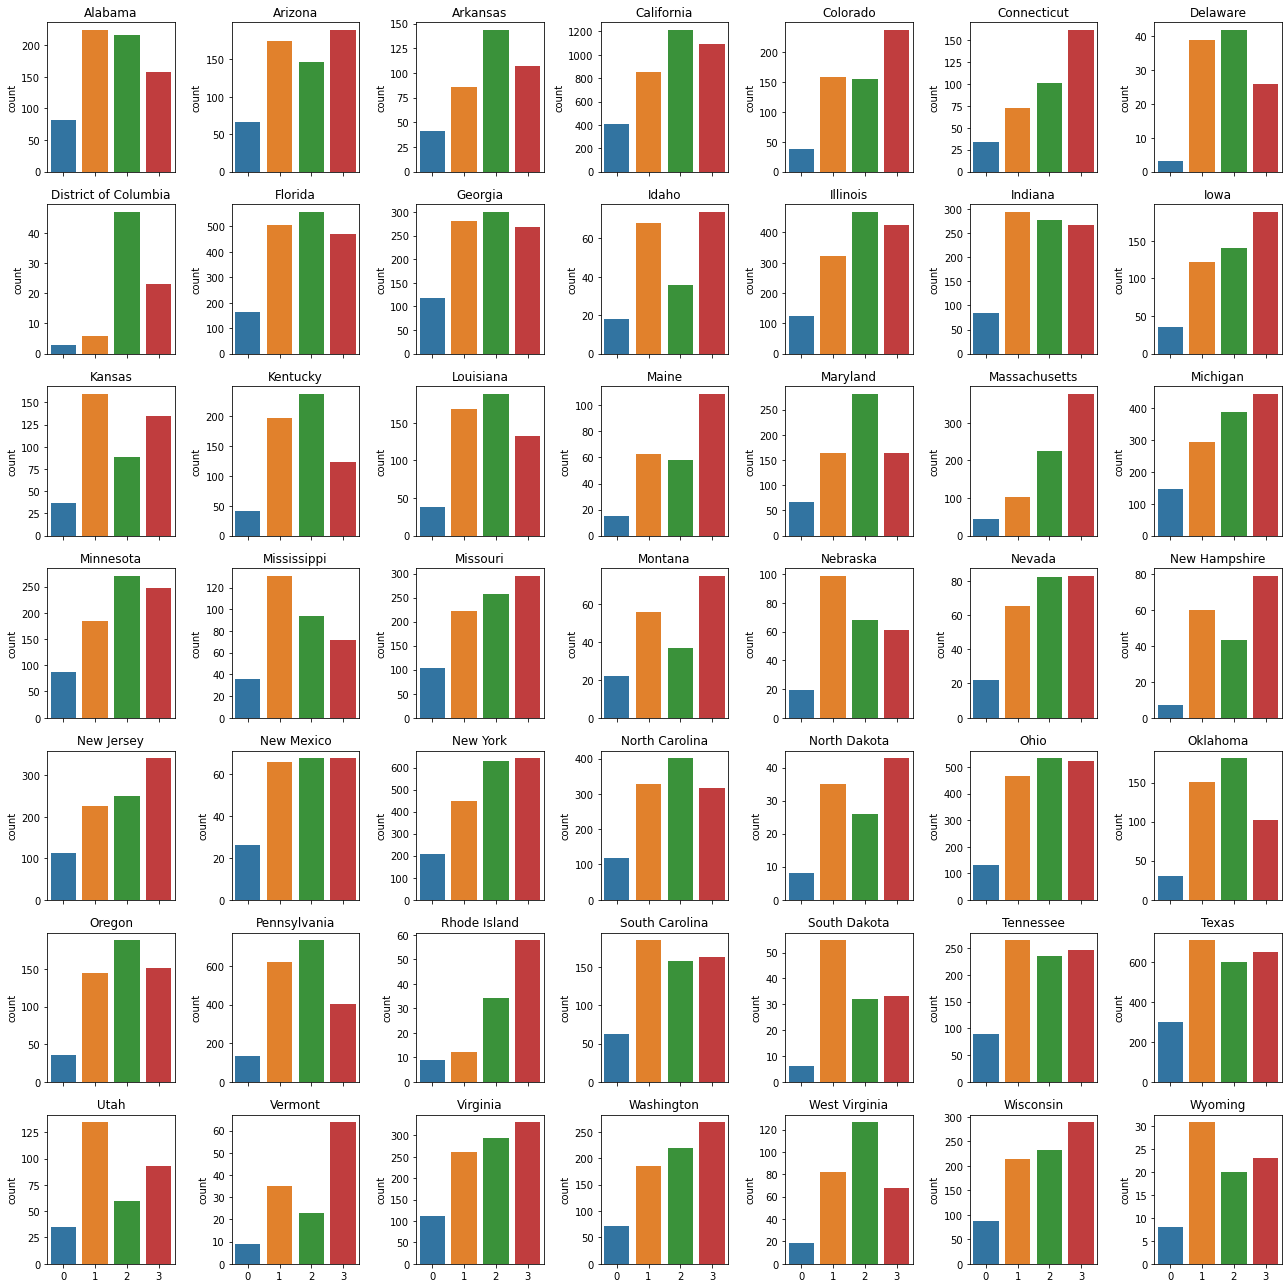

In [38]:
fig,axes = plt.subplots(7,7,figsize=(18,18), sharex=True)
axes = axes.ravel() # flatten
for i in range(len(partyByStateRed2007)):
    sns.countplot(ax= axes[i], x=partyByStateRed2007['partyCode2007'][i], data=partyByStateRed2007).set(title =partyByStateRed2007['state'][i]);
    
plt.tight_layout()
plt.show()

In [39]:
relByState2014 = religion2014df.groupby("state")['qe1'].apply(lambda x: x.tolist()).reset_index()

#import plotly.express as px
#for i in range(len(relByState2014)):
#    fig = px.histogram(relByState2014, x=relByState['qe1'][i], title=relByState['state'][i])
#    fig.show()

religion2014df_reduced = religion2014df[['state', 'qe1', 'party']].copy().apply(lambda x: x.str.strip())


religion2014df_reduced['relCode2014'] = religion2014df_reduced['qe1'].apply(relCode)
religion2014df_reduced['partyCode2014'] = religion2014df_reduced['party'].apply(partyCode)

relByStateRed2014 = religion2014df_reduced.groupby("state")['relCode2014'].apply(lambda x: x.tolist()).reset_index()
partyByStateRed2014 = religion2014df_reduced.groupby("state")['partyCode2014'].apply(lambda x: x.tolist()).reset_index()

#for i in range(len(relByStateRed)):
#    fig = px.histogram(relByStateRed, x=relByStateRed['relCode'][i], title=relByStateRed['state'][i])
#    fig.show()

pd.Series(relByStateRed2014.relCode2014[0]).value_counts(sort=False, normalize = True).tolist()

relByStateRed2014['relFreq2014'] = relByStateRed2014['relCode2014'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
partyByStateRed2014['partyFreq2014'] = partyByStateRed2014['partyCode2014'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
split_reldf14 = pd.DataFrame(relByStateRed2014['relFreq2014'].tolist(), columns=['rel0_2014', 'rel1_2014', 'rel2_2014', 'rel3_2014', 'rel4_2014', 'rel5_2014'])
split_partydf14 = pd.DataFrame(partyByStateRed2014['partyFreq2014'].tolist(), columns=['par0_2014', 'par1_2014', 'par2_2014', 'par3_2014'])

byState = byState.join(split_reldf14).join(split_partydf14)
byState.head()

state  rel0_2007  rel1_2007  rel2_2007  rel3_2007  rel4_2007  \
0     Alabama   0.071953   0.826725   0.004405   0.066079   0.001468   
1     Arizona   0.200692   0.394464   0.041522   0.249135   0.015571   
2    Arkansas   0.092593   0.804233   0.005291   0.047619   0.050265   
3  California   0.198657   0.019026   0.026021   0.340795   0.267208   
4    Colorado   0.227119   0.427119   0.022034   0.189831   0.022034   

   rel5_2007  par0_2007  par1_2007  par2_2007  ...  rel0_2014  rel1_2014  \
0   0.029369   0.120411   0.330396   0.317181  ...   0.099804   0.761252   
1   0.098616   0.114187   0.302768   0.254325  ...   0.322581   0.361290   
2        NaN   0.108466   0.227513   0.380952  ...   0.251149   0.395100   
3   0.148293   0.114717   0.340515   0.239508  ...   0.170418   0.691318   
4   0.111864   0.064407   0.269492   0.262712  ...   0.281850   0.015959   

   rel2_2014  rel3_2014  rel4_2014  rel5_2014  par0_2014  par1_2014  \
0   0.007828   0.074364   0.003914   0.052838   0.099804   0.320939   
1   0.035484   0.148387   0.003226   0.129032   0.109677   0.219355   
2   0.055130   0.192956   0.019908   0.085758   0.078101   0.287902   
3   0.009646   0.070740   0.057878        NaN   0.096463   0.250804   
4   0.033811   0.309981   0.237490   0.120909   0.096024   0.341628   

   par2_2014  par3_2014  
0   0.260274   0.318982  
1   0.161290   0.509677  
2   0.228178   0.405819  
3   0.254019   0.398714  
4   0.201785   0.360563  

[5 rows x 21 columns]

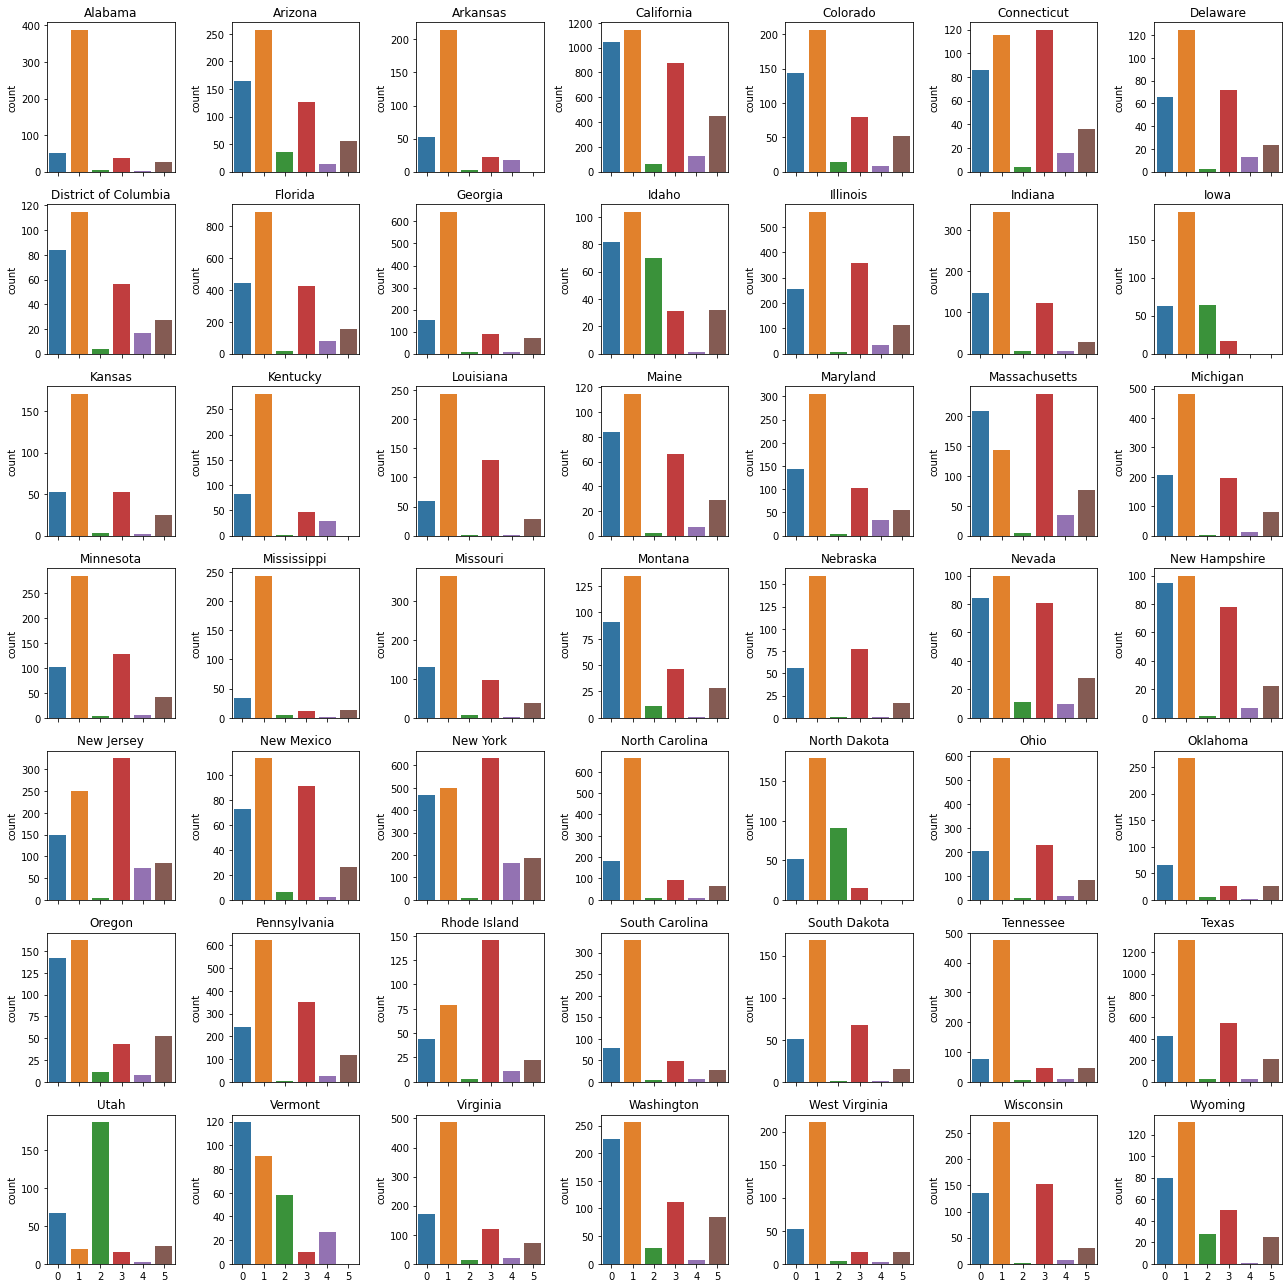

In [40]:
fig,axes = plt.subplots(7,7,figsize=(18,18), sharex=True)
axes = axes.ravel() # flatten
relByStateRed2014_cont = relByStateRed2014[(relByStateRed2014['state'] != 'Alaska') & (relByStateRed2014['state'] != 'Hawaii')].copy().reset_index()

for i in range(len(relByStateRed2007)):
    sns.countplot(ax= axes[i], x=relByStateRed2014_cont['relCode2014'][i], data=relByStateRed2014_cont).set(title =relByStateRed2014_cont['state'][i]);
    
plt.tight_layout()
plt.show()

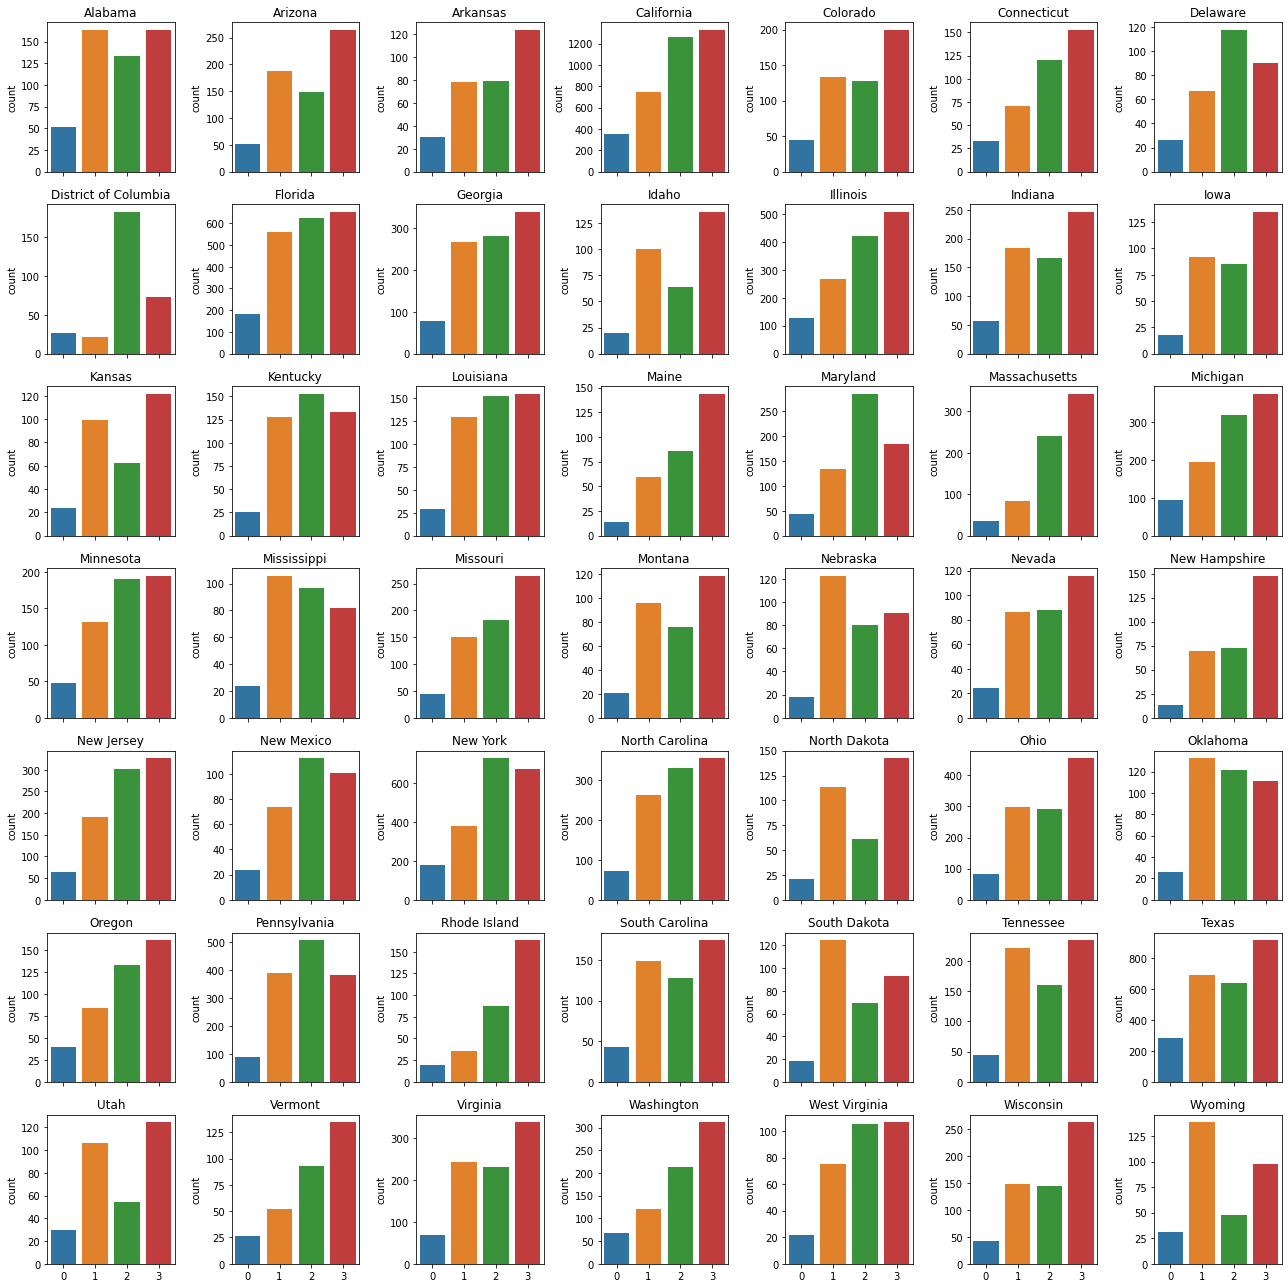

In [41]:
partyByState2014_c = partyByStateRed2014[(partyByStateRed2014['state'] != 'Alaska') & (partyByStateRed2014['state'] != 'Hawaii')].copy().reset_index()
fig,axes = plt.subplots(7,7,figsize=(18,18), sharex=True)
axes = axes.ravel() # flatten
for i in range(len(partyByState2014_c)):
    sns.countplot(ax= axes[i], x=partyByState2014_c['partyCode2014'][i], data=partyByState2014_c).set(title =partyByState2014_c['state'][i]);
    
plt.tight_layout()
plt.show()

In [42]:
byState.state.unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [43]:
features = pd.merge(byState, byStateSentObj, on='state', how='inner')
features.head()

/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning:

merging between different levels can give an unintended result (1 levels on the left,2 on the right)

/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



state  rel0_2007  rel1_2007  rel2_2007  rel3_2007  rel4_2007  \
0     Alabama   0.071953   0.826725   0.004405   0.066079   0.001468   
1     Arizona   0.200692   0.394464   0.041522   0.249135   0.015571   
2    Arkansas   0.092593   0.804233   0.005291   0.047619   0.050265   
3  California   0.198657   0.019026   0.026021   0.340795   0.267208   
4    Colorado   0.227119   0.427119   0.022034   0.189831   0.022034   

   rel5_2007  par0_2007  par1_2007  par2_2007  ...  par2_2014  par3_2014  \
0   0.029369   0.120411   0.330396   0.317181  ...   0.260274   0.318982   
1   0.098616   0.114187   0.302768   0.254325  ...   0.161290   0.509677   
2        NaN   0.108466   0.227513   0.380952  ...   0.228178   0.405819   
3   0.148293   0.114717   0.340515   0.239508  ...   0.254019   0.398714   
4   0.111864   0.064407   0.269492   0.262712  ...   0.201785   0.360563   

   (sentiment_Vader, mean)  (sentiment_Vader, median)  (sentiment_nltk, mean)  \
0                 0.254666                     0.3400                0.398392   
1                 0.263664                     0.3612                0.394860   
2                 0.247887                     0.3071                0.398796   
3                 0.312512                     0.4404                0.451876   
4                 0.280940                     0.4019                0.422206   

   (sentiment_nltk, median)  (sentiment_TextBlob, mean)  \
0                   0.56470                    0.130834   
1                   0.50000                    0.137682   
2                   0.51855                    0.147803   
3                   0.61240                    0.134621   
4                   0.58590                    0.139945   

   (sentiment_TextBlob, median)  (objectivity_TextBlob, mean)  \
0                      0.125000                      0.423527   
1                      0.134167                      0.432791   
2                      0.142532                      0.435235   
3                      0.133209                      0.434680   
4                      0.136364                      0.436882   

   (objectivity_TextBlob, median)  
0                        0.421429  
1                        0.435821  
2                        0.429107  
3                        0.437110  
4                        0.440000  

[5 rows x 29 columns]

In [44]:
fileName = 'featuresCapstone.pkl'
features.to_pickle(fileName)

In [45]:
sightings_merged = pd.read_pickle('sightings_merged.pkl')

Bucketizing the sentiment values for use in classification models

In [46]:
def sentimentLabel(x):
    if x >=0.6:
        return 'very positive'
    if x >= 0.2:
        return 'positive'
    if x >= -0.2:
        return 'neutral'
    if x >= -0.6:
        return 'negative'
    return 'very negative'

sentCols = ['sentiment_Vader','sentiment_nltk', 'sentiment_TextBlob']

for col in sentCols:
    sightings_merged[f'{col}_label'] = sightings_merged[col].apply(sentimentLabel)

In [47]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

sent_Vader_le = le.fit_transform(sightings_merged.sentiment_Vader_label)
sightings_merged['sentiment_Vader_label_encode'] = sent_Vader_le

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = sightings_merged[['rel0_2007', 'rel1_2007', 'rel2_2007',
               'rel3_2007', 'rel4_2007',
               'rel5_2007', 'par0_2007', 'par1_2007', 'par2_2007', 'par3_2007',
               'rel0_2014', 'rel1_2014', 'rel2_2014', 'rel3_2014', 'rel4_2014', 
               'rel5_2014','par0_2014', 'par1_2014', 'par2_2014', 'par3_2014']]

X_PCA = sightings_merged[['rel1_2007', 'rel1_2014','par2_2014', 'rel2_2007', 'rel3_2014', 'par3_2014', 'rel3_2007']]

# 'sentiment_Vader_label', 'sentiment_nltk_label', 'sentiment_TextBlob_label'
y = sightings_merged['sentiment_Vader_label_encode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(X_PCA, y, test_size=.2, stratify=y, random_state=42)

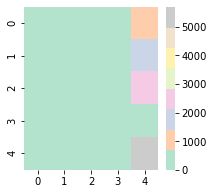

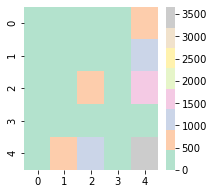

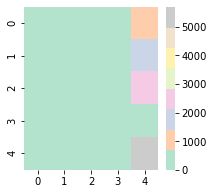

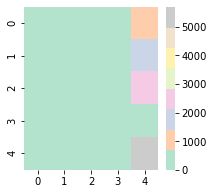

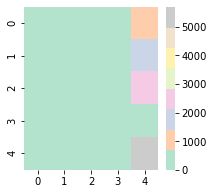

Model  Training accuracy  Test accuracy
0                        MultinomialNB()           0.471270       0.471323
1   KNeighborsClassifier(n_neighbors=14)           0.371951       0.375321
2     LogisticRegression(max_iter=10000)           0.471270       0.471323
3  MLPClassifier(alpha=1, max_iter=1000)           0.471270       0.471323
4     SVC(decision_function_shape='ovo')           0.471270       0.471323

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

results_df = pd.DataFrame(columns = ["Model", "Training accuracy", "Test accuracy"])

class_list = [MultinomialNB(), KNeighborsClassifier(14), LogisticRegression(max_iter=10000), MLPClassifier(alpha=1, max_iter=1000), SVC(decision_function_shape='ovo')]

for mod in class_list:
    class_model = mod
    class_model.fit(X_train, y_train)

    class_model_pred_train = class_model.predict(X_train)
    class_model_pred_test = class_model.predict(X_test)
    
    acc_train = accuracy_score(y_train, class_model_pred_train)
    acc_test = accuracy_score(y_test, class_model_pred_test)
    
    cm = confusion_matrix(y_test, class_model_pred_test)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm,annot=False, cmap="Pastel2");
    plt.show()

    temp = pd.DataFrame({"Model": [mod],
                         "Training accuracy": [acc_train], 
                         "Test accuracy": [acc_test]})
    results_df = results_df.append(temp, ignore_index=True)
results_df

Checking value counts to detemine if un-balanced.  When confirmed, used SMOTE to balance data and re-fit to the classification models.

In [51]:
sightings_merged['sentiment_Vader_label_encode'].value_counts()

4    28471
2    12908
1     9890
0     6737
3     2406
Name: sentiment_Vader_label_encode, dtype: int64

In [52]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_trainPCA, y_trainPCA)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({4: 22776, 2: 22776, 0: 22776, 1: 22776, 3: 22776})
Testing target statistics: Counter({4: 5695, 2: 2582, 1: 1978, 0: 1347, 3: 481})


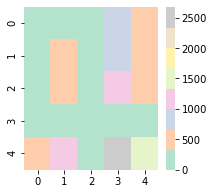

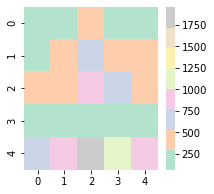

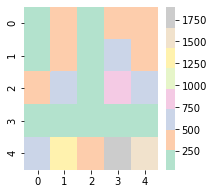

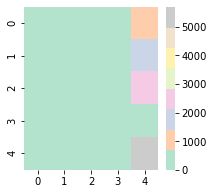

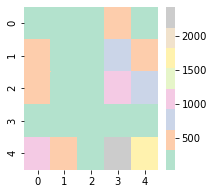

Model  Training accuracy  Test accuracy
0                        MultinomialNB()           0.210098       0.184474
1   KNeighborsClassifier(n_neighbors=14)           0.203469       0.195730
2     LogisticRegression(max_iter=10000)           0.212487       0.207233
3  MLPClassifier(alpha=1, max_iter=1000)           0.200000       0.471323
4     SVC(decision_function_shape='ovo')           0.219670       0.194157

In [53]:
results_df = pd.DataFrame(columns = ["Model", "Training accuracy", "Test accuracy"])

class_list = [MultinomialNB(), KNeighborsClassifier(14), LogisticRegression(max_iter=10000), MLPClassifier(alpha=1, max_iter=1000), SVC(decision_function_shape='ovo')]

for mod in class_list:
    class_model = mod
    class_model.fit(X_res, y_res)

    class_model_pred_train = class_model.predict(X_res)
    class_model_pred_test = class_model.predict(X_testPCA)
    
    acc_train = accuracy_score(y_res, class_model_pred_train)
    acc_test = accuracy_score(y_test, class_model_pred_test)
    
    cm = confusion_matrix(y_testPCA, class_model_pred_test)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm,annot=False, cmap="Pastel2");
    plt.show()

    temp = pd.DataFrame({"Model": [mod],
                         "Training accuracy": [acc_train], 
                         "Test accuracy": [acc_test]})
    results_df = results_df.append(temp, ignore_index=True)
results_df

In [54]:
fileName = 'sightings_merged_w_label.pkl'
sightings_merged.to_pickle(fileName)